In [1]:
using Revise

INFO: Recompiling stale cache file /Users/ortner/.julia/lib/v0.6/Revise.ji for module Revise.


In [2]:
using PyPlot, JuLIP, ForwardDiff

function layers(at)
    dz = 1/(2*√2) * ( bulk(:Si, cubic=true) |> defm )[1,1]
    x, y, z = xyz(at)
    I0 = find(z .<= 0.5*dz)
    I1 = find(0.5*dz .< z .<= 1.5*dz)
    I2 = find(1.5*dz .< z .<= 2.5*dz)
    I3 = find(z .> 2.5*dz)
    return [x[I0]'; y[I0]'], [x[I1]'; y[I1]'], [x[I2]'; y[I2]'], [x[I3]'; y[I3]']
end 

function plot_layers(at, x0=nothing)
    X0, X1, X2, X3 = layers(at)
    plot(X0[1,:], X0[2,:], "b.", markersize=8)
    plot(X1[1,:], X1[2,:], "g.", markersize=8)
    plot(X2[1,:], X2[2,:], "r.", markersize=8)
    plot(X3[1,:], X3[2,:], "y.", markersize=8)
    if x0 != nothing 
        plot([x0[1]], [x0[2]], "r.", markersize=10)
    end 
end

reload("JuLIPMaterials")
Si = JuLIPMaterials.Si
sw = Si.sw_eq()
;

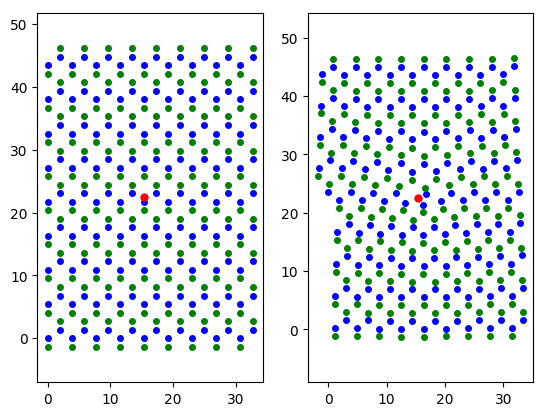

(-3.512964599727193, 35.13361519923379, -3.632362332099854, 48.82546561750301)

In [4]:
at, _, x0 = Si.si110_cluster(:Si, 9)
edge, xc = Si.edge110(:Si, 9)
figure()
subplot(1,2,1)
plot_layers(at, x0)
axis("equal")
subplot(1,2,2)
plot_layers(edge, x0)
axis("equal")

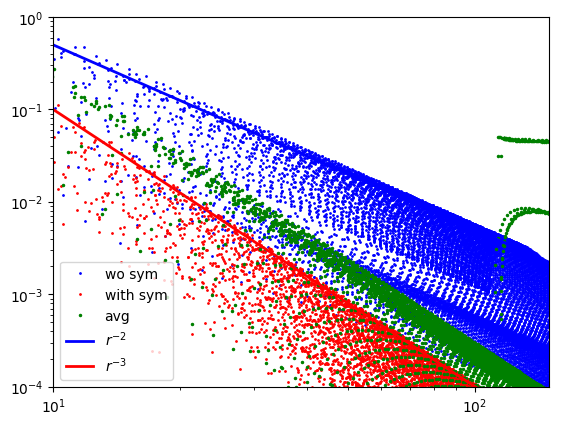

4-element Array{Float64,1}:
  10.0   
 150.0   
   0.0001
   1.0   

In [5]:
R = 61

at_nosym, xc = Si.edge110(:Si, R; calc = sw, sym=false)
r_nosym = [norm(x - xc) for x in positions(at_nosym)]
F = forces(at_nosym)
f_nosym = norm.(F)
J0, J1, Jdel = Si.si_multilattice(at_nosym; TOL=0.5)
f_avg = norm.(F[J0] .+ F[J1])
r_avg = r_nosym[J0]

at_sym, xc = Si.edge110(:Si, R; calc = sw, sym=true)
r_sym = [norm(x - xc) for x in positions(at_sym)]
f_sym = norm.(forces(at_sym))

# plotting preparation
r0 = rnn(:Si)*2
x, y, _ = xyz(at_sym)
xL, xR = extrema(x); yL, yR = extrema(y)
Iint = find( (xL+2*r0 .< x .< xR - 2*r0) .* (yL+2*r0 .< y .< yR - 2*r0) )
s = [extrema(r_sym)...]
r_sym, f_sym, r_nosym, f_nosym = r_sym[Iint], f_sym[Iint], r_nosym[Iint], f_nosym[Iint]

s = [extrema(r_sym)...]
loglog(r_nosym, f_nosym, "b.", markersize=2, label = "wo sym")
loglog(r_sym, f_sym, "r.", markersize=2, label = "with sym")
loglog(r_avg, f_avg, "g.", markersize=3, label = "avg")
loglog(s, 50*s.^(-2), "b-", linewidth = 2.0, label = L"r^{-2}")
loglog(s, 100*s.^(-3), "r-", linewidth = 2.0, label = L"r^{-3}")
legend(loc="lower left")
axis([10, 150, 1e-4, 1.0])

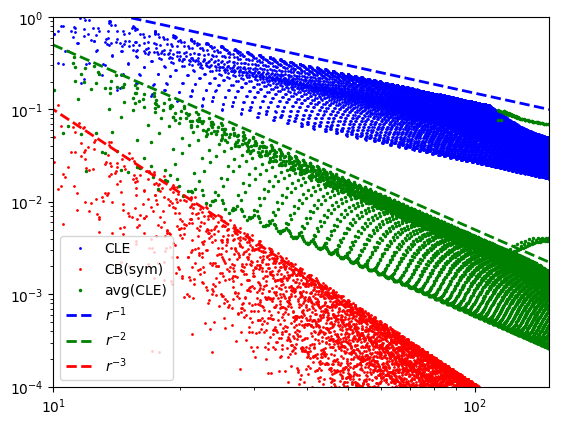

4-element Array{Float64,1}:
  10.0   
 150.0   
   0.0001
   1.0   

In [9]:
R = 61

at_nosym, xc = Si.edge110(:Si, R; calc = sw, sym=nothing)
r_nosym = [norm(x - xc) for x in positions(at_nosym)]
F = forces(at_nosym)
f_nosym = norm.(F)
J0, J1, Jdel = Si.si_multilattice(at_nosym; TOL=0.5)
f_avg = norm.(F[J0] .+ F[J1])
r_avg = r_nosym[J0]

at_sym, xc = Si.edge110(:Si, R; calc = sw, sym=true)
r_sym = [norm(x - xc) for x in positions(at_sym)]
f_sym = norm.(forces(at_sym))

# plotting preparation
r0 = rnn(:Si)*2
x, y, _ = xyz(at_sym)
xL, xR = extrema(x); yL, yR = extrema(y)
Iint = find( (xL+2*r0 .< x .< xR - 2*r0) .* (yL+2*r0 .< y .< yR - 2*r0) )
s = [extrema(r_sym)...]
r_sym, f_sym, r_nosym, f_nosym = r_sym[Iint], f_sym[Iint], r_nosym[Iint], f_nosym[Iint]

s = [extrema(r_sym)...]
loglog(r_nosym, f_nosym, "b.", markersize=2, label = "CLE")
loglog(r_sym, f_sym, "r.", markersize=2, label = "CB(sym)")
loglog(r_avg, f_avg, "g.", markersize=3, label = "avg(CLE)")
loglog(s, 15*s.^(-1), "b--", linewidth = 2.0, label = L"r^{-1}")
loglog(s, 50*s.^(-2), "g--", linewidth = 2.0, label = L"r^{-2}")
loglog(s, 100*s.^(-3), "r--", linewidth = 2.0, label = L"r^{-3}")
legend(loc="lower left")
axis([10, 150, 1e-4, 1.0])

## Convergence Tests

In [162]:
include("ErrorAnalysis.jl")
ERR = ErrorAnalysis
sw = Si.sw_eq()
rbuf = 2 * cutoff(sw)

SS = [3, 5, 8, 12, 17, 23, 30]
S_ex = 90
RR = SS * 1.1 * rnn(:Si)
R_ex = S_ex * 1.1 * rnn(:Si)
;

In [163]:
si_cell_mult(R) =
   (ceil(Int, 3 * R / cell(bulk(:Si, cubic=true))[1,1]) ÷ 2) * 2 + 1

function ref_cluster(R; kwargs...)
      L = si_cell_mult(R+rbuf)
      at, xc = Si.edge110(:Si, L; calc = sw, kwargs...)
      set_data!(at, :xc, xc)
      return at
end


ref_cluster (generic function with 1 method)

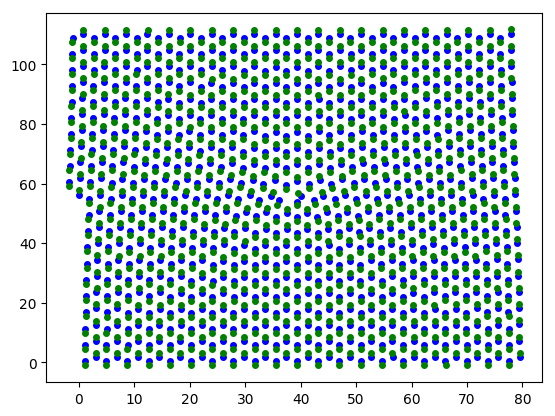

In [135]:
# check that the reference configuration looks ok
at = ref_cluster(30; sym = nothing)
plot_layers(at)

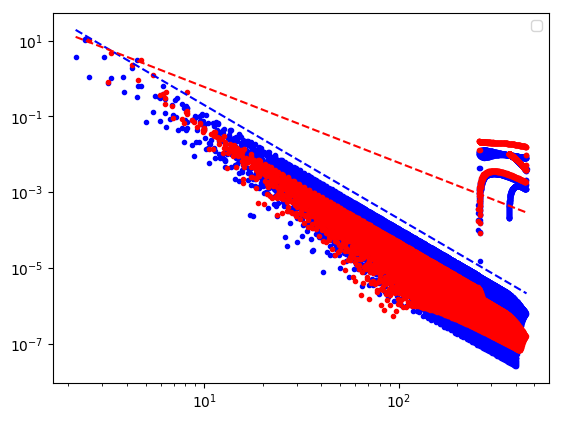

PyObject <matplotlib.legend.Legend object at 0x176ec8510>

In [231]:
# check that the force decay remains ok!
at_ref = ref_cluster(240; sym=true)
xc = get_data(at_ref, :xc)
F = forces(sw, at_ref)
f = norm.(F)
X = positions(at_ref)
r = [norm(x-xc) for x in X]

J0, J1, Jdel = Si.si_multilattice(at_ref; TOL=0.5)
f_avg = norm.(F[J0] .+ F[J1])
r_avg = r[J0]

loglog(r, f, "b.")
loglog(r_avg, f_avg, "r.")
s = [extrema(r)...]
loglog(s, 200* s.^(-3), "b--", s, 60*s.^(-2), "r--")
legend("f", "f_avg")

In [232]:
netFs = Float64[]
RR2 = [RR; [100, 130, 170, 220]]
for R in RR2
    IR = find(r .< R)
    Fnet = sum(F[IR])
    @show Fnet
    push!(netFs, norm(Fnet))
end 

Fnet = [0.305351, 0.0194529, 1.23164e-12]
Fnet = [0.03296, 0.029266, -3.84674e-13]
Fnet = [-0.0121501, 0.00940907, 1.22507e-13]
Fnet = [0.000573145, 0.0052146, 7.70506e-14]
Fnet = [-0.00375246, 0.000312387, -3.78846e-14]
Fnet = [-0.000789768, 0.000797033, 1.20086e-13]
Fnet = [-0.000941135, 0.000693209, -4.47847e-14]
Fnet = [-0.000773053, 0.00028033, -1.64082e-13]
Fnet = [0.000162726, 0.000179802, 1.44172e-13]
Fnet = [4.73162e-5, 0.000103082, -1.62609e-13]
Fnet = [-4.49691e-6, 3.14484e-5, -1.11446e-13]


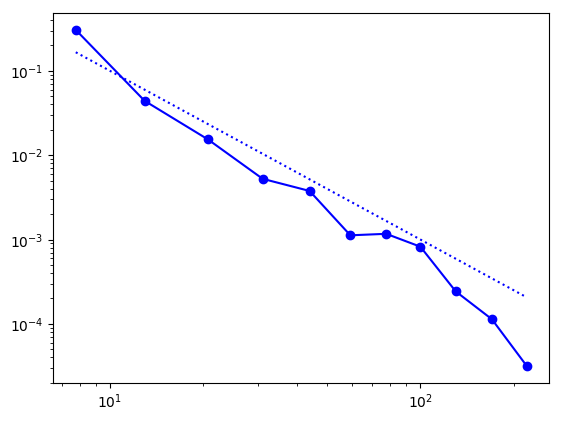

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x173229a50>
 PyObject <matplotlib.lines.Line2D object at 0x174ba6a50>

In [233]:
loglog(RR2, netFs, "bo-", RR2, 10*RR2.^(-2), "b:")

In [278]:
function setup_edge(R, at_ref; verbose=false)
   X0 = positions(at_ref)
   xc = get_data(at_ref, :xc)
   r = [norm(x[1:2]-xc[1:2]) for x in X0]
   IR = find(r .<= R+rbuf)
   at = Atoms(:Si, X0[IR])
   set_cell!(at, cell(at_ref))
   set_constraint!(at, FixedCell(at, clamp = find(r[IR] .> R)))
   set_calculator!(at, sw)
   set_pbc!(at, (false, false, true))
   set_data!(at, :IR, IR)
   set_data!(at, :X0, X0[IR])
   set_data!(at, :xc, xc)
   return at 
end



function solve_edge(R, at_ref; verbose=false)
   at = setup_edge(R, at_ref; verbose=verbose)
   P = JuLIP.Preconditioners.FF(at, sw)
   minimise!(at; verbose=verbose, gtol = 1e-8, precond=P)
   H = hessian(at)
   g = gradient(at)
   x = dofs(at)
   x -= H \ g 
   set_dofs!(at, x)
   g = gradient(at)
   @show norm(g, Inf)
   return at
end

Base.error(at::Atoms, at_ex::Atoms) =
      ERR.error_energynorm(positions(at),    get_data(at,    :X0),
                           positions(at_ex), get_data(at_ex, :X0), rnn(:Si))

function error_local(at::Atoms, at_ex::Atoms)
    xc = get_data(at, :xc)
    X = positions(at)
    Rat = maximum(norm(x - xc) for x in X)
    
    X = positions(at_ex)
    X0 = get_data(at_ex, :X0)
    Iat = find([norm(x - xc) <= 1.1*Rat for x in X])
    at_comp = Atoms(:Si, X[Iat])
    @show length(at_ex), length(at_comp)
    return ERR.error_energynorm(positions(at), get_data(at,    :X0),
                           positions(at_comp), X0[Iat], rnn(:Si))
end


error_local (generic function with 1 method)

In [279]:
at_ref = ref_cluster(R_ex; sym = true)
at_ex = solve_edge(R_ex, at_ref; verbose=true)

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [225.59676891888665,128.13261915460524, ...]
 * Minimizer: [225.5967648231808,128.13256664733987, ...]
 * Minimum: -1.501701e+05
 * Iterations: 23
 * Convergence: true
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 8.39e-08 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 5.32e-06 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 47
 * Gradient Calls: 24
norm(g, Inf) = 9.550539525893242e-11


JuLIP.Atoms{Float64,Int64}
  X: Array{StaticArrays.SArray{Tuple{3},Float64,1,3}}((34813,))
  P: Array{StaticArrays.SArray{Tuple{3},Float64,1,3}}((34813,))
  M: Array{Float64}((34813,)) [28.085, 28.085, 28.085, 28.085, 28.085, 28.085, 28.085, 28.085, 28.085, 28.085  …  28.085, 28.085, 28.085, 28.085, 28.085, 28.085, 28.085, 28.085, 28.085, 28.085]
  Z: Array{Int64}((34813,)) [14, 14, 14, 14, 14, 14, 14, 14, 14, 14  …  14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
  cell: StaticArrays.SArray{Tuple{3,3},Float64,2,9}
  pbc: StaticArrays.SArray{Tuple{3},Bool,1,3}
  calc: JuLIP.Potentials.StillingerWeber{JuLIP.Potentials.Shift{-1,JuLIP.Potentials.AnalyticFunction{JuLIP.Potentials.##46#52{Float64,Float64,Float64,Float64,Int64,Float64},JuLIP.Potentials.##47#53{Float64,Float64,Float64,Float64,Int64,Float64},JuLIP.Potentials.##48#54{Float64,Float64,Float64,Float64,Int64,Float64}}},JuLIP.Potentials.Shift{-1,JuLIP.Potentials.AnalyticFunction{JuLIP.Potentials.##49#55{Float64,Float64,Float64,Float64,Float

In [265]:
at_ref = ref_cluster(R_ex; sym = true)
at_ex = solve_edge(R_ex, at_ref)
at_nref = ref_cluster(R_ex; sym = false)
at_nex = solve_edge(R_ex, at_nref)
at_xref = ref_cluster(R_ex; sym = nothing)
at_xex = solve_edge(R_ex, at_xref)
;

In [283]:
err_sym = Float64[]
N_sym = Int[]
err_nsym = Float64[]
N_nsym = Int[]
err_xsym = Float64[]
N_xsym = Int[]


for R in RR
   # sym = true
   at = solve_edge(R, at_ref)
   @show err = error(at, at_ex)
   push!(N_sym, length(at.cons.ifree) ÷ 3)
   push!(err_sym, err)

   # sym = false
   at = solve_edge(R, at_nref)
   @show nerr = error(at, at_nex)
   push!(N_nsym, length(at.cons.ifree) ÷ 3)
   push!(err_nsym, nerr)


   # sym = nothing
   at = solve_edge(R, at_xref)
   @show xerr = error(at, at_xex)
   push!(N_xsym, length(at.cons.ifree) ÷ 3)
   push!(err_xsym, xerr)
end

norm(g, Inf) = 1.4748480214876736e-12
err = error(at, at_ex) = 0.5796718194182793
norm(g, Inf) = 1.7393089831995034e-12
nerr = error(at, at_nex) = 0.5065558241455292
norm(g, Inf) = 1.8286909631698694e-12
xerr = error(at, at_xex) = 0.7041056265655816
norm(g, Inf) = 1.5850237788939125e-12
err = error(at, at_ex) = 0.5031717754724183
norm(g, Inf) = 1.6765616672742567e-12
nerr = error(at, at_nex) = 0.4405917136532958
norm(g, Inf) = 2.2497559371004172e-12
xerr = error(at, at_xex) = 0.6197091321762119
norm(g, Inf) = 2.3433199825007023e-12
err = error(at, at_ex) = 0.43457899507231945
norm(g, Inf) = 1.7765233728539442e-12
nerr = error(at, at_nex) = 0.379261021335624
norm(g, Inf) = 2.048486380523684e-12
xerr = error(at, at_xex) = 0.5463952245225918
norm(g, Inf) = 3.4129643555758093e-12
err = error(at, at_ex) = 0.37759151876393054
norm(g, Inf) = 2.2507204433530603e-12
nerr = error(at, at_nex) = 0.33074560022273614
norm(g, Inf) = 2.3468310628160793e-12
xerr = error(at, at_xex) = 0.4846777574508568

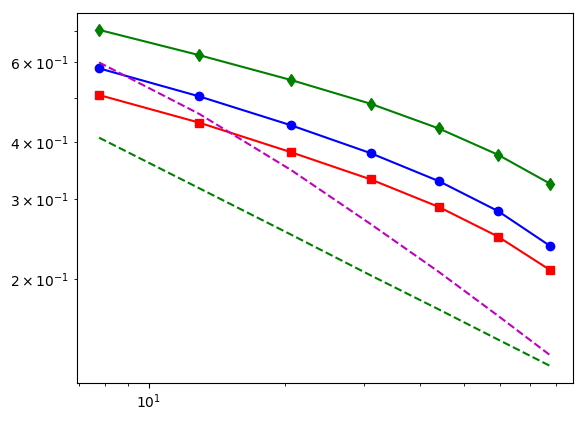

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13d415510>

In [286]:
loglog(RR, err_sym, "bo-")
loglog(RR, err_nsym, "rs-")
loglog(RR, err_xsym, "gd-")
# loglog(N_sym, N_sym.^(-0.5), "b--")
loglog(RR, N_nsym.^(-0.25), "g--")
loglog(RR, log.(N_sym) .* N_sym.^(-0.5), "m--")

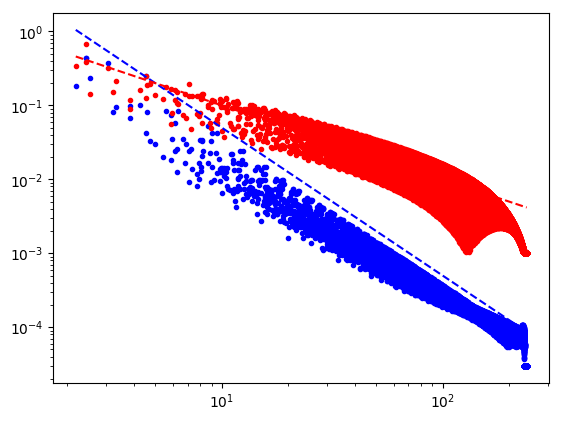

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13ce23b50>

In [281]:
X0 = get_data(at_ex, :X0)
xc = get_data(at_ex, :xc)
u = norm.(positions(at_ex) - X0)
e = JuLIPMaterials.strains(positions(at_ex) - X0, at_ex; rcut = 1.5 * rnn(:Si))
r = [norm(x - xc) for x in X0]
s = [extrema(r)...]
loglog(r, e + 3e-5, "b.")
loglog(r, u + 1e-3, "r.")
loglog(s, 5*s.^(-2), "b--")
loglog(s, s.^(-1), "r--")

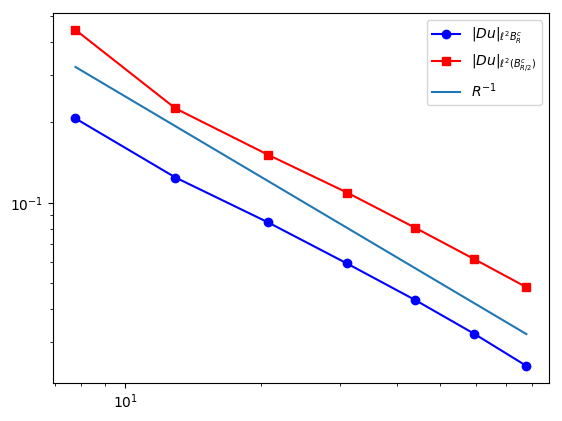

PyObject <matplotlib.legend.Legend object at 0x17b79dd90>

In [259]:
outer_nrm = Float64[]
outer_nrm2 = Float64[]
for R in RR
    Iout = find(r .> R)
    push!(outer_nrm, norm(e[Iout]))
    Iout = find(r .> R/2)
    push!(outer_nrm2, norm(e[Iout]))
end 
loglog(RR, outer_nrm, "bo-", RR, outer_nrm2, "rs-")
loglog(RR, 2.5*RR.^(-1))
legend((L"\|Du\|_{\ell^2{B_R^c}}", L"\|Du\|_{\ell^2(B_{R/2}^c)}", L"R^{-1}"))

In [260]:
# at = setup_edge(R_ex, at_ref)
# xc = get_data(at, :xc)
# x, y, _ = xyz(at)
# # r = (x-xc[1]).^2 + (y-xc[2]).^2
# Ifree = at.cons.ifree[3:3:end] .÷ 3
# Iclamp = setdiff(1:length(x), Ifree)
# plot(x[Ifree], y[Ifree], "r.", ms=1)
# plot(x[Iclamp], y[Iclamp], "b.", ms=1)